# Projekt zaliczeniowy Bootcamp Data Science ING


Temat 2: Przewidywanie wzięcia pożyczki. Celem projektu jest zastosowanie modeli klasyfikacji (binarnej) do przewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku.

# Importy bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# Wczytanie danych

In [2]:
DATA = 'https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv'
dane = pd.read_csv(DATA, encoding = 'latin1', index_col = 'ID', parse_dates = ['Lead_Creation_Date', 'DOB'])
dane.shape

(87020, 25)

Zgodnie z poleceniem usuwam od razu zmienną LoggedIn

In [3]:
dane = dane.drop(columns = 'LoggedIn')
dane.shape

(87020, 24)

Patrzę na ogólne informacje o zbiorze

In [4]:
dane.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87020 entries, ID000002C20 to ID124821V10
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Gender                 87020 non-null  object        
 1   City                   86017 non-null  object        
 2   Monthly_Income         87020 non-null  int64         
 3   DOB                    87020 non-null  datetime64[ns]
 4   Lead_Creation_Date     87020 non-null  datetime64[ns]
 5   Loan_Amount_Applied    86949 non-null  float64       
 6   Loan_Tenure_Applied    86949 non-null  float64       
 7   Existing_EMI           86949 non-null  float64       
 8   Employer_Name          86949 non-null  object        
 9   Salary_Account         75256 non-null  object        
 10  Mobile_Verified        87020 non-null  object        
 11  Var5                   87020 non-null  int64         
 12  Var1                   87020 non-null  object    

# Podział na zbiór treningowy i testowy

In [5]:
X, y = dane.drop(columns = 'Disbursed'), dane.Disbursed
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.3)

In [6]:
X_train.shape

(60914, 23)

In [7]:
X_test.shape

(26106, 23)

# Analiza zmiennych objaśniających

Najpierw analizuję zmienne datowe, potem kategoryczne, a na końcu numeryczne

## 1. Zmienne datowe

In [8]:
X_train.DOB.describe()

count                   60914
unique                  10450
top       1980-11-11 00:00:00
freq                      218
first     1970-01-01 00:00:00
last      2069-12-31 00:00:00
Name: DOB, dtype: object

In [9]:
X_train.Lead_Creation_Date.describe()

count                   60914
unique                     92
top       2015-07-03 00:00:00
freq                     1623
first     2015-05-01 00:00:00
last      2015-07-31 00:00:00
Name: Lead_Creation_Date, dtype: object

Na początku poprawiam wartości dla zmiennej DOB tam, gdzie rok błędnie się wczytał jako 20xx, a nie 19xx

In [10]:
X_train['DOB'] = X_train.DOB.astype(str)
X_train['DOB_year'] = X_train.DOB.str[:4].astype(int)
X_train['DOB_month'] = X_train.DOB.str[5:7].astype(int)
X_train['DOB_day'] = X_train.DOB.str[8:10].astype(int)
X_train.loc[X_train['DOB_year'] >= 2000, 'DOB_year'] -= 100
X_train["DOB"] = pd.to_datetime(X_train.DOB_year*10000+X_train.DOB_month*100+X_train.DOB_day,format='%Y%m%d')

X_train.DOB.describe()

count                   60914
unique                  10450
top       1980-11-11 00:00:00
freq                      218
first     1915-06-20 00:00:00
last      1997-12-19 00:00:00
Name: DOB, dtype: object

Analogiczna operacja na zbiorze testowym

In [11]:
X_test['DOB'] = X_test.DOB.astype(str)
X_test['DOB_year'] = X_test.DOB.str[:4].astype(int)
X_test['DOB_month'] = X_test.DOB.str[5:7].astype(int)
X_test['DOB_day'] = X_test.DOB.str[8:10].astype(int)
X_test.loc[X_test['DOB_year'] >= 2000, 'DOB_year'] -= 100
X_test["DOB"] = pd.to_datetime(X_test.DOB_year*10000+X_test.DOB_month*100+X_test.DOB_day,format='%Y%m%d')

X_test.DOB.describe()

count                   26106
unique                   8112
top       1980-11-11 00:00:00
freq                       88
first     1915-07-06 00:00:00
last      1997-12-25 00:00:00
Name: DOB, dtype: object

Zmienne Lead_Creation_Date i DOB same w sobie nie mają merytoryczngego związu ze zmienną celu. Dlatego zamiast brać je bezpośrednio tworzę zmienną, która będzie różnicą w latach między Lead_Creation_Date a DOB. Zmienna ta informuje o wieku klienta.

In [12]:
X_train["Age"] = X_train['Lead_Creation_Date'] - X_train['DOB']
X_train["Age"] = (X_train["Age"] / np.timedelta64(1, 'D')).astype(int)
X_train["Age"] /= 365

X_test["Age"] = X_test['Lead_Creation_Date'] - X_test['DOB']
X_test["Age"] = (X_test["Age"] / np.timedelta64(1, 'D')).astype(int)
X_test["Age"] /= 365

Usuwam już niepotrzebne zmienne.

In [13]:
X_train = X_train.drop(columns = ['DOB','DOB_year','DOB_month','DOB_day','Lead_Creation_Date'])
X_test = X_test.drop(columns = ['DOB','DOB_year','DOB_month','DOB_day','Lead_Creation_Date'])

## 2. Zmienne kategoryczne

In [14]:
X_train.Gender.value_counts()/len(X_train)

Male      0.571937
Female    0.428063
Name: Gender, dtype: float64

In [15]:
X_train.City.value_counts()/len(X_train)

Delhi         0.144712
Mumbai        0.123945
Bengaluru     0.123157
Hyderabad     0.082641
Chennai       0.079801
                ...   
Tarn Taran    0.000016
Kandhamal     0.000016
Mokokchung    0.000016
Namchi        0.000016
Lohardaga     0.000016
Name: City, Length: 662, dtype: float64

In [16]:
X_train.Employer_Name.value_counts()/len(X_train)

0                                               0.056375
TATA CONSULTANCY SERVICES LTD (TCS)             0.006402
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD    0.004498
GOOGLE                                          0.003727
ACCENTURE SERVICES PVT LTD                      0.003628
                                                  ...   
JABIL SERVICES PVT LTD                          0.000016
NEBULA E KIDS                                   0.000016
WIPRO TNERPRISES LTD                            0.000016
MAVERIC SOLUTION&CONSULTANCY PVT LTD            0.000016
ARPIT GOUR                                      0.000016
Name: Employer_Name, Length: 33022, dtype: float64

In [17]:
X_train.Salary_Account.value_counts()/len(X_train)

HDFC Bank                                          0.203681
ICICI Bank                                         0.156499
State Bank of India                                0.137473
Axis Bank                                          0.100174
Citibank                                           0.026841
Kotak Bank                                         0.023640
IDBI Bank                                          0.017976
Punjab National Bank                               0.014069
Bank of India                                      0.013183
Bank of Baroda                                     0.013133
Standard Chartered Bank                            0.011426
Union Bank of India                                0.011262
Canara Bank                                        0.011130
Yes Bank                                           0.008701
ING Vysya                                          0.007601
Corporation bank                                   0.007338
State Bank of Hyderabad                 

In [18]:
X_train.Mobile_Verified.value_counts()/len(X_train)

Y    0.649095
N    0.350905
Name: Mobile_Verified, dtype: float64

In [19]:
X_train.Var1.value_counts()/len(X_train)

HBXX    0.682930
HBXC    0.104180
HBXB    0.051220
HAXA    0.033047
HBXA    0.024231
HAXB    0.022540
HBXD    0.022015
HAXC    0.017697
HBXH    0.010901
HCXF    0.008175
HAYT    0.005779
HAVC    0.004432
HAXM    0.003168
HCXD    0.002610
HCYS    0.002462
HVYS    0.002265
HAZD    0.001313
HCXG    0.000903
HAXF    0.000131
Name: Var1, dtype: float64

In [20]:
X_train.Filled_Form.value_counts()/len(X_train)

N    0.776981
Y    0.223019
Name: Filled_Form, dtype: float64

In [21]:
X_train.Device_Type.value_counts()/len(X_train)

Web-browser    0.741767
Mobile         0.258233
Name: Device_Type, dtype: float64

In [22]:
X_train.Var2.value_counts()/len(X_train)

B    0.430213
G    0.379798
C    0.161342
E    0.015300
D    0.007108
F    0.006173
A    0.000066
Name: Var2, dtype: float64

In [23]:
X_train.Source.value_counts()/len(X_train)

S122    0.443281
S133    0.343353
S159    0.063959
S143    0.050350
S127    0.021703
S137    0.019716
S134    0.015382
S161    0.009128
S151    0.008077
S157    0.007305
S153    0.005516
S144    0.003661
S156    0.003595
S158    0.002528
S123    0.000788
S141    0.000607
S162    0.000394
S124    0.000213
S160    0.000148
S150    0.000082
S138    0.000049
S129    0.000049
S136    0.000033
S155    0.000033
S125    0.000016
S135    0.000016
S139    0.000016
Name: Source, dtype: float64

Zgodnie z opisem danych zmienną Var4 traktuję jako znakową, a nie numeryczną

In [24]:
X_train["Var4"] = X_train.Var4.astype("object")
X_test["Var4"] = X_test.Var4.astype("object")

X_train.Var4.value_counts()/len(X_train)

3    0.292527
1    0.273730
5    0.231901
4    0.075483
2    0.068326
0    0.029025
7    0.026267
6    0.002742
Name: Var4, dtype: float64

Missingi przypisuję do kategorii 'Missing'

In [25]:
for variable in ['Gender', 'City', 'Employer_Name', 'Salary_Account', 'Mobile_Verified', 
                 'Var1', 'Filled_Form','Device_Type', 'Var2', 'Source', 'Var4']:
    X_train.loc[X_train[variable].isna(), variable] = 'Missing'
    X_test.loc[X_test[variable].isna(), variable] = 'Missing'

Dla niektórych zmiennych jest bardzo dużo unikalnych wartości. Z tego powodu tworzę funkcję, która będzie zostawiać tylko te wartości, któych udział jest powyżej 2%, a pozostałe zamieniać na "Other". Ponadto kategorię 'Missing' zawsze zostawiam, ponieważ to specyficzna kategoria.

In [26]:
def kateg_transf(variable):
    
    prog = len(X_train)*0.02
    
    result = {}
    result_fin = {}
    
    lista_wartosci = list(X_train[variable])
    
    for value in lista_wartosci:
        if value not in result:
            result[value] = 1
        else:
            result[value] += 1
    
    for value in list(result.keys()):
        if result[value] > prog:
            result_fin[value] = result[value]
        
    czeste_wartosci = list(result_fin.keys())
    czeste_wartosci = czeste_wartosci + ['Missing']
    X_train.loc[~X_train[variable].isin(czeste_wartosci), variable] = 'Other'
    X_test.loc[~X_test[variable].isin(czeste_wartosci), variable] = 'Other'

Wywołuję funkcję dla 5 zmiennych, które mają więcej niż 1 kategorię poniżej progu 2%.

In [27]:
kateg_transf('City')
kateg_transf('Salary_Account')
kateg_transf('Var1')
kateg_transf('Var2')
kateg_transf('Source')

Zmienna Employer_Name jest najbardziej rozdrobniona. Dla niej wybieram 20 najliczniejszych kategorii, a pozostałym przypisuję wartość 'Other'. 

In [28]:
employers_n = X_train.Employer_Name.value_counts()
najwięksi_employers = list(employers_n.index[:20])
najwięksi_employers.sort()

X_train.loc[~X_train['Employer_Name'].isin(najwięksi_employers), 'Employer_Name' ] = 'Other'
X_test.loc[~X_test['Employer_Name'].isin(najwięksi_employers), 'Employer_Name' ] = 'Other'

In [29]:
X_test.Employer_Name.value_counts()

Other                                           23418
0                                                1480
TATA CONSULTANCY SERVICES LTD (TCS)               160
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD      130
ACCENTURE SERVICES PVT LTD                        103
GOOGLE                                             74
HCL TECHNOLOGIES LTD                               72
ICICI BANK LTD                                     72
INDIAN AIR FORCE                                   59
INFOSYS TECHNOLOGIES                               57
IBM CORPORATION                                    54
GENPACT                                            52
WIPRO TECHNOLOGIES                                 48
INDIAN ARMY                                        47
IKYA HUMAN CAPITAL SOLUTIONS LTD                   45
HDFC BANK LTD                                      44
TYPE SLOWLY FOR AUTO FILL                          44
ARMY                                               39
INDIAN RAILWAY              

Dla wszystkich zmiennych kategorycznych robię transformację Weight of Evidence, żeby potem zmienne kategoryczne można było łatwo wziąć do budowy modelu razem ze zmiennymi numerycznymi.

In [30]:
All_train = X_train.merge(y_train, on='ID')

for variable in ['Gender', 'City', 'Employer_Name', 'Salary_Account', 'Mobile_Verified', 
                 'Var1', 'Filled_Form','Device_Type', 'Var2', 'Source', 'Var4']:
    
    value_list = []
    
    for value in list(All_train[variable].unique()):
        value_list.append({
            'Value': value,
            'All': All_train[All_train[variable] == value].count()[variable],
            'Goods': All_train[(All_train[variable] == value) & (All_train['Disbursed'] == 1)].count()[variable],
            'Bads': All_train[(All_train[variable] == value) & (All_train['Disbursed'] == 0)].count()[variable]
        })
    woe_list = pd.DataFrame(value_list)
    woe_list['Distr_Goods'] = woe_list['Goods'] / woe_list['Goods'].sum()
    woe_list['Distr_Bads'] = woe_list['Bads'] / woe_list['Bads'].sum()
    woe_list['WoE'] = np.log(woe_list['Distr_Goods'] / woe_list['Distr_Bads'])
    woe_list = woe_list.replace({'WoE': {np.inf: 0, -np.inf: 0}})
       
    woe_dict = dict(zip(woe_list['Value'], woe_list['WoE']))
        
    X_train[variable] = X_train[variable].replace(woe_dict)
    X_test[variable] = X_test[variable].replace(woe_dict)
    
    print(f'{variable}: {woe_dict}')

Gender: {'Male': 0.29126851645913804, 'Female': -0.5917537731674928}
City: {'Other': -0.24046166105754777, 'Bengaluru': 0.10612154858839849, 'Mumbai': 0.07412975673370006, 'Chennai': -0.45604108445662744, 'Delhi': 0.29403825163759306, 'Hyderabad': -0.18390928177971752, 'Missing': -1.6221916989006944, 'Ahmedabad': 0.07306735035078127, 'Pune': 0.5811084887882836, 'Kolkata': 0.025826665904069224}
Employer_Name: {'Other': 0.03488018683712165, 'GENPACT': 0.7911054185091828, '0': -2.3135906272671103, 'GOOGLE': 0.0, 'HDFC BANK LTD': 0.70048718458856, 'COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD': 0.5756569034167734, 'ACCENTURE SERVICES PVT LTD': 1.0576337154259166, 'HCL TECHNOLOGIES LTD': 0.4442344746670714, 'ICICI BANK LTD': -0.8949923755948336, 'INDIAN AIR FORCE': 0.0, 'INDIAN ARMY': -0.5951889426107078, 'ARMY': 0.0, 'STATE GOVERNMENT': -0.3781244373728802, 'INDIAN NAVY': -0.2938640937551402, 'TYPE SLOWLY FOR AUTO FILL': 0.5706755730665692, 'INFOSYS TECHNOLOGIES': -0.5951889426107078, 'WIP

## 3. Zmienne numeryczne

Tworzę tabelę z podstawowymi statystykami dla poszcególnych zmiennych oraz wykresy gęstości

In [31]:
X_train_num = X_train[['Monthly_Income'       
 ,'Loan_Amount_Applied'   
 ,'Loan_Tenure_Applied'   
 ,'Existing_EMI'                  
 ,'Var5'                                
 ,'Loan_Amount_Submitted' 
 ,'Loan_Tenure_Submitted'
 ,'Interest_Rate'    
 ,'Processing_Fee'    
 ,'EMI_Loan_Submitted'                                                     
 ,'Age']]

In [32]:
statystyki = X_train_num.describe()
statystyki.index = ['count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max']
statystyki=statystyki.T
missing=pd.DataFrame(X_train_num.isnull().sum())
missing.columns=["missing"]
statystyki = statystyki.join(missing)

In [33]:
statystyki

,count,mean,std,min,Q1,median,Q3,max,missing
Monthly_Income,60914.0,53326.727698,1.710813e+06,0.00000,16500.000000,25000.000000,40000.00000,3.838384e+08,0
Loan_Amount_Applied,60864.0,230498.602819,3.514932e+05,0.00000,0.000000,100000.000000,300000.00000,9.999999e+06,50
Loan_Tenure_Applied,60864.0,2.143320,2.014516e+00,0.00000,0.000000,2.000000,4.00000,1.000000e+01,50
Existing_EMI,60864.0,3686.607008,4.164019e+04,0.00000,0.000000,0.000000,3500.00000,1.000000e+07,50
Var5,60914.0,4.960649,5.661877e+00,0.00000,0.000000,2.000000,11.00000,1.800000e+01,0
Loan_Amount_Submitted,36706.0,394901.650956,3.093099e+05,50000.00000,200000.000000,300000.000000,500000.00000,3.000000e+06,24208
Loan_Tenure_Submitted,36706.0,3.890154,1.166357e+00,1.00000,3.000000,4.000000,5.00000,6.000000e+00,24208
Interest_Rate,19314.0,19.214590,5.845559e+00,11.99000,15.250000,18.000000,20.00000,3.700000e+01,41600
Processing_Fee,19099.0,5112.117179,4.705056e+03,200.00000,2000.000000,3900.000000,6238.50000,5.000000e+04,41815
EMI_Loan_Submitted,19314.0,10976.268523,7.485150e+03,1185.56000,6318.280000,9338.600000,12823.07250,1.447483e+05,41600


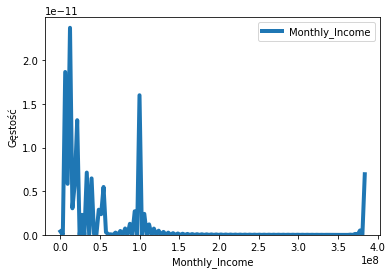

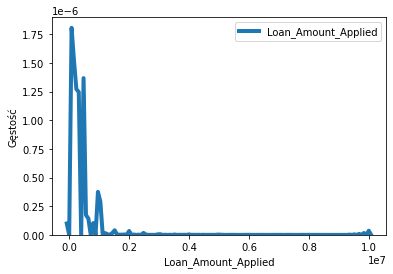

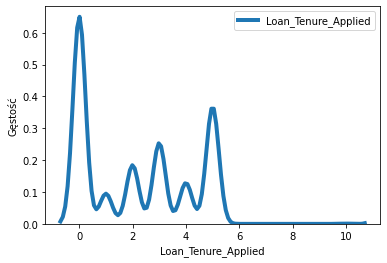

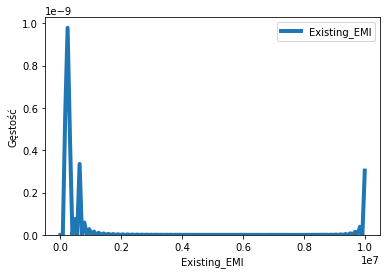

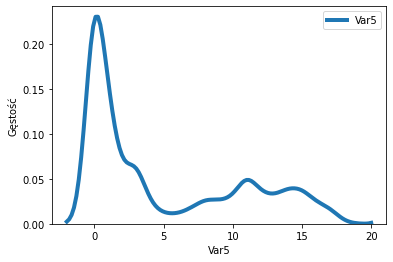

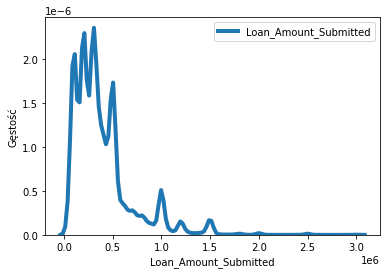

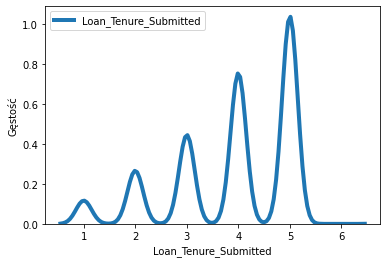

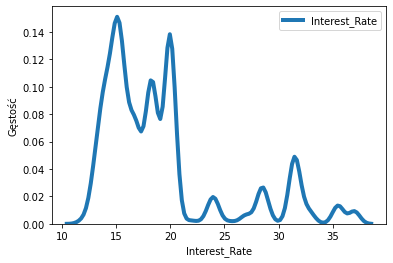

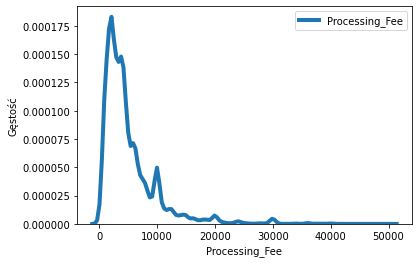

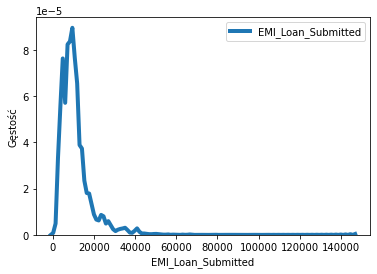

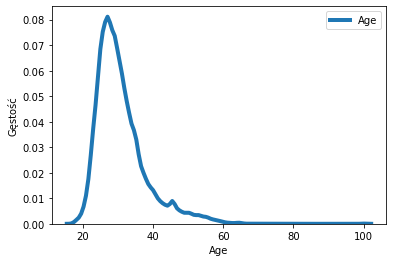

In [34]:
for variable in X_train_num.columns:
    sns.distplot(X_train_num[variable], hist = False, kde_kws = {'linewidth': 4},label = variable)
    plt.xlabel(variable)
    plt.ylabel('Gęstość')
    plt.show()

Widać, że 8 z 11 zmiennych ma braki. Zastępuję je medianami wyliczonymi na zbiorze treningowym. 

In [35]:
for variable in X_train_num.columns: 
    X_train.loc[X_train[variable].isna(), variable] = statystyki['median'][variable]
    X_test.loc[X_test[variable].isna(), variable] = statystyki['median'][variable]

# Moc dyskryminacyjna zmiennych

Przed puszczeniem modeli sprawdzam moc dyskryminacyjną poszczególnych zmiennych miarą AUC zarówno na zbiorze treningowym jak i testowym.

In [36]:
result_train={}
result_test={}

for variable in X_train.columns:

    AUC_train=roc_auc_score(y_train, X_train[variable])
    result_train[variable] = AUC_train
    AUC_test=roc_auc_score(y_test, X_test[variable])
    result_test[variable] = AUC_test
    
result_train = pd.DataFrame.from_dict(result_train, orient='index', columns=['AUC_train'])
result_test = pd.DataFrame.from_dict(result_test, orient='index', columns=['AUC_test'])
result_fin = result_train.join(result_test)

In [37]:
result_fin.sort_values(by='AUC_train', ascending=False)

,AUC_train,AUC_test
Monthly_Income,0.786693,0.788868
Var5,0.752595,0.730895
Var4,0.648029,0.615261
Salary_Account,0.639839,0.637238
Var1,0.638594,0.608445
Existing_EMI,0.613231,0.616769
Age,0.612765,0.632291
Loan_Amount_Applied,0.608719,0.612963
Gender,0.596220,0.575777
Mobile_Verified,0.592617,0.576131


# Modele

Buduję model wykorzystując po kolei 3 metody klasyfikacji: regresję logistyczną, drzewo decyzyjne, las losowy. Następnie porównuję wyniki uzyskane przy użyciu tych metod.

In [38]:
np.mean(y_train)

0.01452867977804774

In [39]:
np.mean(y_test)

0.014862483720217574

Widać też, że występuje niezbalansowanie klas. Dlatego będę ważył klasy.

## 1. Regresja logistyczna

In [40]:
pipe = Pipeline([("scale", StandardScaler()),
                 ("log_reg", LogisticRegression())])

param_grid = {"log_reg__penalty": ["l1", "l2"],
              "log_reg__C": [10, 1, 0.1, 0.01],
              "log_reg__class_weight": [{0:1, 1:10}, {0:1, 1:15}, {0:1, 1:50}, {0:1, 1:100}]}

gs_reg=GridSearchCV(pipe, param_grid, scoring='f1', cv=3, n_jobs=-1)
gs_reg.fit(X_train, y_train)
gs_reg.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=10, class_weight={0: 1, 1: 15}))])

In [41]:
accuracy_reg = accuracy_score(y_test, gs_reg.best_estimator_.predict(X_test))
f1_reg = f1_score(y_test, gs_reg.best_estimator_.predict(X_test))
AUC_reg = roc_auc_score(y_test, gs_reg.best_estimator_.predict_proba(X_test)[:,1])

## 2. Drzewo decyzyjne

In [42]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [10, 20, 50, 100],
              "min_samples_leaf": [1, 5, 10],
              "class_weight": [{0:1, 1:10}, {0:1, 1:15}, {0:1, 1:50}, {0:1, 1:100}]}

gs_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='f1', cv=3, n_jobs=-1)
gs_tree.fit(X_train, y_train)
gs_tree.best_estimator_

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=10)

In [43]:
accuracy_tree = accuracy_score(y_test, gs_tree.best_estimator_.predict(X_test))
f1_tree = f1_score(y_test, gs_tree.best_estimator_.predict(X_test))
AUC_tree = roc_auc_score(y_test, gs_tree.best_estimator_.predict_proba(X_test)[:,1])

## 3. Las losowy

In [44]:
param_grid = {"n_estimators": [2, 10, 20],
              "criterion": ["gini","entropy"],
              "max_depth": [10, 20, 50, 100],
              "min_samples_leaf": [1, 5, 10],
              "class_weight": [{0:1, 1:10}, {0:1, 1:15}, {0:1, 1:50}, {0:1, 1:100}]}

gs_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=3, n_jobs=-1)
gs_forest.fit(X_train, y_train)
gs_forest.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=100,
                       min_samples_leaf=10, n_estimators=20)

In [45]:
accuracy_forest = accuracy_score(y_test, gs_forest.best_estimator_.predict(X_test))
f1_forest = f1_score(y_test, gs_forest.best_estimator_.predict(X_test))
AUC_forest = roc_auc_score(y_test, gs_forest.best_estimator_.predict_proba(X_test)[:,1])

## Podsumowanie modeli

Porównuję modele miarami Accuracy, F1 oraz AUC wyliczonymi na zbiorze testowym.

In [46]:
Podsumowanie=pd.DataFrame({
                    'Accuracy': [accuracy_reg, accuracy_tree, accuracy_forest],
                    'F1': [f1_reg, f1_tree, f1_forest],
                    'AUC': [AUC_reg, AUC_tree, AUC_forest]
                     },
                    index = ['Regresja logistyczna', 'Drzewo decyzyjne', 'Las losowy'])

In [47]:
Podsumowanie

,Accuracy,F1,AUC
Regresja logistyczna,0.954800,0.119403,0.804343
Drzewo decyzyjne,0.962576,0.084349,0.699655
Las losowy,0.966483,0.111675,0.818942


Otrzymane modele mają średnią moc dyskryminacyjną. Najlepsze wydają się modele otrzymane regresją logistyczną i lasem losowym.